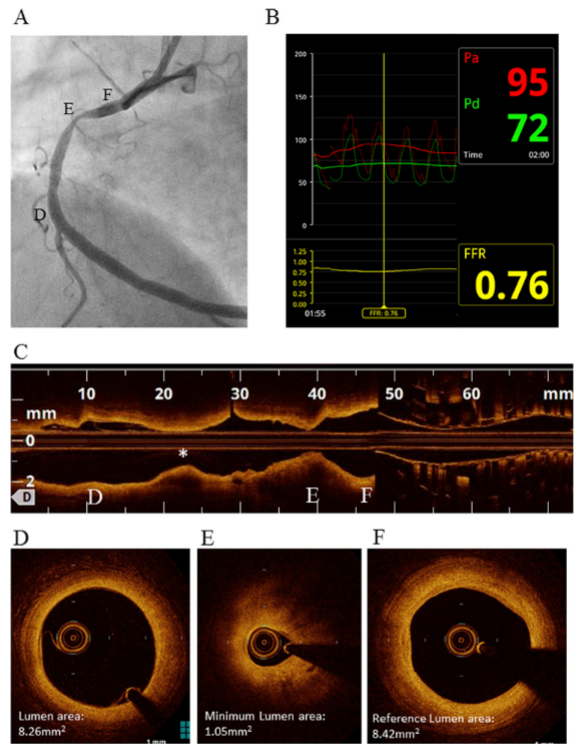

## 计算F和S

OCT-derived FFR由原始方法计算得到, 主要需要计算的是压力损失$\Delta P$,计算公式为$\Delta P = FV + SV^2$. 

其中, 前一项为粘性摩擦引起的压力损失, 被称作Poiseuille阻力, 本质上是汇聚处层流的粘性阻力.

后一项为出入口处流体分离引起的压力损失, 被表述为突然增强(abrupt enhancement)阻力, 本质上是流体发散引起涡流造成的阻力, 作用处为血管分叉口.

$V$ 是血液流速, $F$和$S$计算公式如下
$$
F = \frac{8\pi \mu L}{A_s}\frac{A_n}{A_s}\\
S = \frac{\rho}2\left(\frac{A_n}{A_s}-1 \right)^2
$$

> 这里有个问题, 论文中表述$\Delta P$的公式和上面有点出入
> $$
\Delta P =\frac{8\pi \mu L}{A_s}\frac{A_n}{A_s}\times V + \frac{k}{2}\left(\frac{A_n}{A_s}-1 \right)^2\times V^2
$$
> 可以看到上面是$\rho$, 而下面是$k$

里面一些常数的数值和解释如下

- $\mu = 4.0\times 10 ^{-3}Pa\cdot s$  绝对血液粘度
- $\rho = 1050 kg/m^3$  血液密度
- $k = 1$: 与出/入口效应有关的常数

另外一些数值需要从OCT中得到

- $L$ 狭窄段长度
  - 如果只是狭窄段长度, 那需要L = 1.85mm左右, 大约是18个切片的长度. 虽然数值凑对了, 但因为不好判断狭窄段范围, 因此应不是正解
  - **在本篇文章中应该是是每张切片计算一个F然后全部加起来**
    - D到F大概是35mm, 切片间距离为0.1mm,总共有350个切片,如果全部是最大面积(An),计算出来的F是0.0313 mmHg s/cm, 如果全部是最小面积(As)计算出来的F是2.02mmHg s/cm, 按图上估计最窄处大概只有5%, 按比例平均一下最后结果大概是0.131,和最终结果相近.

> 按照此猜想, 更准确的公式应该为
> $$
F = \sum_i^N \frac{8\pi \mu L_{OCT}}{A_{s_i}}\frac{A_n}{A_{s_i}}\\
$$
> 其中$N$是狭窄段总的切片数,$L_{OCT}$是两张切片间距离, ${A_{s_i}}$是每一个目标切片的管腔面积

-  $A_n$是正常动脉的截面积(参考面积)

  - 远端/近端管腔截面积中较大的一个
  - **这里也有个问题, 远端和近端的位置是如何确定的?**

- $A_s$是狭窄目标的截面积, 在计算S时使用最小管腔面积(minimum lumen area (MLA))

下面先尝试计算S和F



In [3]:
#设置常数, 所有数据单位都是基本单位
mu = 4.0e-3
rho = 1050
k = 1
L_OCT = 100e-6 #OCT切片相隔距离

In [11]:
#第一个例子中的数据
#远端管腔面积
distal_lumen_area = 8.26e-6
#近端管腔面积
proximal_lumen_area = 8.42e-6
#狭窄处截面积, MLA
As = 1.05e-6
#参考截面积
An = max(distal_lumen_area, proximal_lumen_area)
print("An = %e m^2"%An)

#狭窄处长度,按第一种想法估计,从结果看可能是18张切片总和
L = 1.8e-3

An = 8.420000e-06 m^2


In [12]:
#计算, 最后结果保留三位有效数字
import math
F = 8*math.pi*mu*L*An/As/As
S = rho/2*(An/As-1)**2
F_mmHg_s_div_cm = F*0.0075*0.01
S_mmHg_s2_div_cm2 = S*0.0075*0.01*0.01
print("F = %f Pa s/m"%F)
print("F = {:.3} mmHg s/cm".format(F_mmHg_s_div_cm))
print("S = %f kg/m^3"%S)
print("S = {:.3} mmHg s^2/cm^s".format(S_mmHg_s2_div_cm2))

F = 1381.993020 Pa s/m
F = 0.104 mmHg s/cm
S = 25865.190476 kg/m^3
S = 0.0194 mmHg s^2/cm^s


In [6]:
#估计一下第二种算法的可行性
F_max_area = 8*math.pi*mu*L_OCT*An/An/An*0.0075*0.01*350
F_min_area = 8*math.pi*mu*L_OCT*An/As/As*0.0075*0.01*350
print("F_max_area = {:.3}mmHg s/cm".format(F_max_area))
print("F_min_area = {:.3}mmHg s/cm".format(F_min_area))
print("95:5比例, 平均为{:.3}mmHg s/cm".format(F_max_area*0.95+F_min_area*0.05))

F_max_area = 0.0313mmHg s/cm
F_min_area = 2.02mmHg s/cm
95:5比例, 平均为0.131mmHg s/cm


可以看到, S计算结果和文献中一样, F如果按18张切片总和来理解与最终结果还是有所偏差, 而按第二种算法, 起码文献结果在这个范围里, 而且与估计值相近

## 计算SFR

假设平均动脉压为 100 mmHg, 可以绘制 **(狭窄处远端)的冠状动脉压力** 与 **相对冠状动脉流量(relative coronary flow)** 关系图来确定 **狭窄血流储备(stenosis flow reserve SFR)**

可以理解为在不同的血液流速下, 血管会收到不同的灌注压, 当这一压力与100-Pc(正常压力-压力损失)相等时达到平衡.

研究中分为收缩期SFR(systolic SFR)和舒张期SFR(diastolic SFR)

曲线$P_c = 100-\Delta P$  与  **充血条件下冠状动脉灌注压**曲线 的交点是**充血条件下远端冠状动脉血管区域的SFR**

| | 舒张期(diastolic) | 收缩期(systolic) | 平均 |
| ------------------------ | ------ | ------ | ---- |
| 基础左冠状动脉血流(cm/s) | 20     | 10     | /    |
| 基础右冠状动脉血流(cm/s) | 15     | 10     | /    |
| 血压(mmHg)               | 60    | 120     | 80   |
| 最大SFR                  | 4.2    | 2.0    | /    |
| 论文中计算得到SFR        | 2.21   | 1.56   | /    |

本题中用到的是右冠状动脉(right coronary artery RCA)数据

$最大血流速度V = 基础冠状动脉血流速度\times SFR$

>  根据Figure 2 ,基础动脉血流速度是20 cm/s
>
> (这里用的是舒张期的基础血流速度吗? 应该不是, 因为后面收缩期计算也用的是20)

舒张时间为整个心动周期的2/3



**充血条件下冠状动脉灌注压**计算:

舒张期: $P = 10+(100-10)/4.2\times V$

收缩期: $P = 10+(100-10)/2\times V$

> 这里Figure 1 与 Figure 2出现了矛盾, 根据Figure 2, 正确的公式应该是将上面的$V$换成SFR, 即
>
> 舒张期$P = 10+(100-10)/4.2\times SFR$
>
> 收缩期$P = 10+(100-10)/2\times SFR$
>
> 这样才能得到一样的结果, 虽然还是不知道这个公式的具体原理
>
> 两个公式可以统一为$P=10+(100-10)\times V/(20SFR_{max})$
>
> 此外, 不知道这里的公式参数是否与左右冠状动脉等其他因素有关, 需要查阅本文参考文献 
> Assessment of coronary stenoses by myocardial perfusion imaging during pharmacologic coronary vasodilation. VII. Validation of coronary flow reserve as a single integrated functional measure of stenosis severity reflecting all its geometric dimensions


$P_c = 100-(FV+SV^2)$

分别联立可以解得
$$
\begin{aligned}
b &= F+\frac{4.5} {SFR_{max}}\\
SFR &= \frac{\sqrt{b^2+360S}-b}{40S}\\
\end{aligned}
$$


In [7]:
# 给定参数, 单位是mmHg 和 cm
F = 0.106
S = 0.0194
SFR_max_dia = 4.2  #舒张 diatolic
SFR_max_sys = 2    #收缩 systolic

In [8]:
b = F+4.5/SFR_max_dia
SFR_dia = (math.sqrt(b**2+360*S)-b)/40/S
print("舒张期SFR={:.3}".format(SFR_dia))

b = F+4.5/SFR_max_sys
SFR_sys = (math.sqrt(b**2+360*S)-b)/40/S
print("收缩期SFR={:.3}".format(SFR_sys))

舒张期SFR=2.21
收缩期SFR=1.53


可以看到结果基本一致, 只是收缩期SFR是1.53, 而文献中给出的是1.56, 但我就算了几次都是前者, 不知道为什么

## 计算FFR

- Fractional Flow Reserve (FFR)（分数流量储备）：
    - FFR是一种生理性指标，用于评估冠状动脉疾病的严重程度。它通过测量冠状动脉内压力来确定狭窄部位对于心肌血流的影响。
    - 在进行FFR测量时，医生会插入导丝进入冠状动脉，然后通过监测冠状动脉的压力来测量狭窄区域与非狭窄区域的压力差。这个压力差与心肌的血流储备相关。
    - FFR的值介于0和1之间，通常0.80被认为是决定是否需要介入治疗（如支架植入）的阈值。FFR小于0.80表示狭窄显著，可能需要治疗。
    
首先用下标中数据计算$\Delta P$的具体数值. 原理是先由基础流速V×SFR计算出真实血流速度, 然后再根据真实血流速度计算出压力损失(或者说是SFR点对应的100-Pc)

| | 舒张期(diastolic) | 收缩期(systolic) | 平均 |
| ------------------------ | ------ | ------ | ---- |
| 基础右冠状动脉血流(cm/s) | 15     | 10     | /    |

In [9]:
V_dia = 15
V_sys = 10

Delta_P_dia = F*V_dia*SFR_dia + S*(V_dia*SFR_dia)**2
Delta_P_sys = F*V_sys*SFR_sys + S*(V_sys*SFR_sys)**2

print("舒张期Delta P={:.3} mmHg".format(Delta_P_dia))
print("收缩期Delta P={:.3} mmHg".format(Delta_P_sys))

舒张期Delta P=24.9 mmHg
收缩期Delta P=6.14 mmHg


同样, 由于收缩期SFR的差别, 收缩期的$\Delta P$也有一定差别

然后根据正常血压计算SFR

| | 舒张期(diastolic) | 收缩期(systolic) | 平均 |
| ------------------------ | ------ | ------ | ---- |
| 血压(mmHg)               | 60    | 120     | 80   |

舒张周期占2/3, 大概分别计算处收缩期和舒张期的FFR, 然后取加权平均

$$
FFR = \frac{(2/3(P_{dia} - \Delta P_{dia}) + 1/3(P_{sys} - \Delta P_{sys}))}{P_{mean}}
$$

In [10]:
P_dia = 60
P_sys = 120
P_mean = 80

FFR = (2/3*(P_dia - Delta_P_dia) + 1/3*(P_sys - Delta_P_sys))/P_mean
print("FFR={:.3} mmHg".format(FFR))

FFR=0.767 mmHg
